In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import *

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

sns.set_style('darkgrid')

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#   tf.config.set_logical_device_configuration(
#     physical_devices[0],
#     [tf.config.LogicalDeviceConfiguration(memory_limit=7000),
#      tf.config.LogicalDeviceConfiguration(memory_limit=7000)])

#   logical_devices = tf.config.list_logical_devices('GPU')
#   assert len(logical_devices) == len(physical_devices) + 1
# except:
#   # Invalid device or cannot modify logical devices once initialized.
#   pass
# tf.config.list_logical_devices('GPU')

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [ ]:
# ds_train = ds_train.take(5_000)
# ds_test  = ds_test.take(5_000)

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

BATCH_SIZE = 256

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

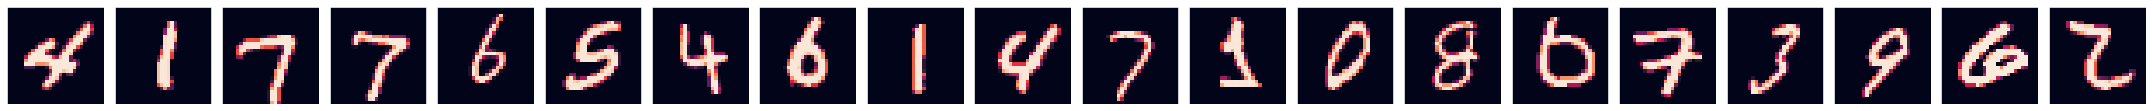

In [ ]:
sample, inner, index = 1, min(BATCH_SIZE, 20), 0
fig, ax = plt.subplots(sample, inner, figsize=(30, 3))

for images, labels in ds_train.take(sample):
  for i in range(inner):
    ax[i].imshow(images[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    index += 1
plt.tight_layout()

In [ ]:
def create_model():

    model = Sequential()

    model.add(layers.Conv2D(filters = 128,kernel_size = 3,activation = "relu", input_shape=(28, 28, 1)))
    model.add(layers.Conv2D(filters = 64,kernel_size = 5,activation = "relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters = 32,kernel_size = 3,activation = "relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32,activation = "relu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10,activation = "softmax"))
    return(model)

def compile_model(model):
    model.compile(optimizer=optimizers.Nadam(),
                loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[metrics.SparseCategoricalAccuracy()]) 
    return(model)

In [ ]:
strategy = tf.distribute.MirroredStrategy()  
with strategy.scope(): 
  model = create_model()
  model = compile_model(model)

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 64)        204864    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 32)          18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 512)              

In [ ]:
history_multi = model.fit(ds_train,validation_data = ds_test,epochs = 10)

2022-04-17 14:07:04.344382: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/10
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1


235/235 [==============================] - ETA: 0s - loss: 0.3950 - sparse_categorical_accuracy: 0.8773

2022-04-17 14:07:13.751602: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


235/235 [==============================] - 12s 23ms/step - loss: 0.3950 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.0771 - val_sparse_categorical_accuracy: 0.9780
Epoch 2/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.0514 - val_sparse_categorical_accuracy: 0.9843
Epoch 3/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0502 - val_sparse_categorical_accuracy: 0.9852
Epoch 4/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0328 - val_sparse_categorical_accuracy: 0.9902
Epoch 5/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0424 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0360 - sparse_categorical_ac

In [ ]:
with tf.device('/device:GPU:0'):
  model = create_model()
  model = compile_model(model)
  history_single = model.fit(ds_train,validation_data = ds_test,epochs = 10)

Epoch 1/10
235/235 [==============================] - 7s 25ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8852 - val_loss: 0.0876 - val_sparse_categorical_accuracy: 0.9743
Epoch 2/10
235/235 [==============================] - 6s 23ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.0636 - val_sparse_categorical_accuracy: 0.9811
Epoch 3/10
235/235 [==============================] - 6s 23ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.0490 - val_sparse_categorical_accuracy: 0.9855
Epoch 4/10
235/235 [==============================] - 6s 23ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0344 - val_sparse_categorical_accuracy: 0.9896
Epoch 5/10
235/235 [==============================] - 6s 23ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0349 - val_sparse_categorical_accuracy: 0.9891
Epoch 6/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0355 - sparse_cate

In [ ]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]                                            # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

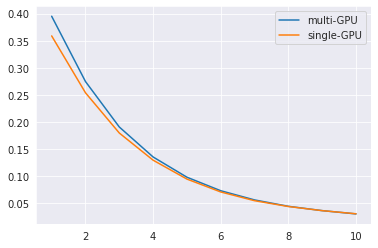

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['loss'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['loss'], 0.6), label='single-GPU')
plt.legend()

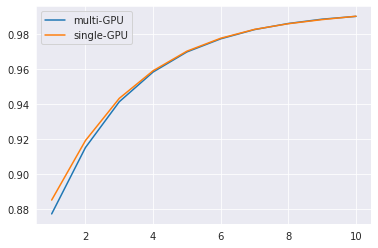

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['sparse_categorical_accuracy'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['sparse_categorical_accuracy'], 0.6), label='single-GPU')
plt.legend()

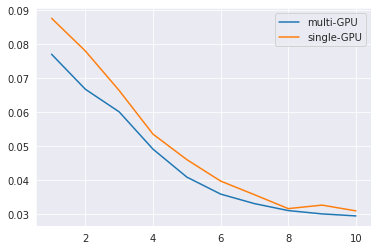

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['val_loss'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['val_loss'], 0.6), label='single-GPU')
plt.legend()

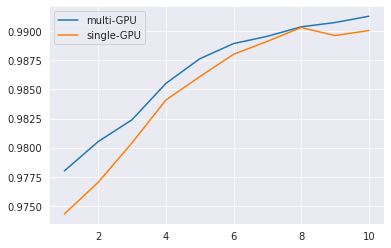

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['val_sparse_categorical_accuracy'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['val_sparse_categorical_accuracy'], 0.6), label='single-GPU')
plt.legend()

# Without ConvNet

In [ ]:
def create_model_linear():

    model = Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(256,activation = "relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128,activation = "relu"))
    model.add(layers.Dense(32,activation = "relu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10,activation = "softmax"))
    return(model)

In [ ]:
strategy = tf.distribute.MirroredStrategy()  
with strategy.scope(): 
  model = create_model_linear()
  model = compile_model(model)

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 10)               

In [ ]:
history_multi = model.fit(ds_train,validation_data = ds_test,epochs = 10)

2022-04-17 15:14:19.475069: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/10


/home/ubuntu/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1


234/235 [============================>.] - ETA: 0s - loss: 0.4521 - sparse_categorical_accuracy: 0.8652

2022-04-17 15:14:26.736472: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


235/235 [==============================] - 9s 15ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.1561 - val_sparse_categorical_accuracy: 0.9549
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: 0.1716 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.1056 - val_sparse_categorical_accuracy: 0.9662
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.1209 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.0838 - val_sparse_categorical_accuracy: 0.9726
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.0802 - val_sparse_categorical_accuracy: 0.9745
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0775 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.0746 - val_sparse_categorical_accuracy: 0.9764
Epoch 6/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0682 - sparse_categorical_accuracy

In [ ]:
with tf.device('/device:GPU:0'):
  model = create_model()
  model = compile_model(model)
  history_single = model.fit(ds_train,validation_data = ds_test,epochs = 10)

Epoch 1/10
235/235 [==============================] - 6s 24ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.8818 - val_loss: 0.0742 - val_sparse_categorical_accuracy: 0.9752
Epoch 2/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.0502 - val_sparse_categorical_accuracy: 0.9847
Epoch 3/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.0366 - val_sparse_categorical_accuracy: 0.9878
Epoch 4/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.0355 - val_sparse_categorical_accuracy: 0.9883
Epoch 5/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0362 - val_sparse_categorical_accuracy: 0.9891
Epoch 6/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0372 - sparse_cate

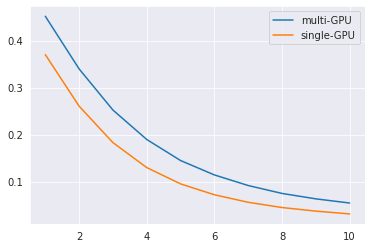

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['loss'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['loss'], 0.6), label='single-GPU')
plt.legend()

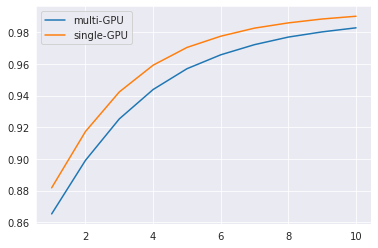

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['sparse_categorical_accuracy'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['sparse_categorical_accuracy'], 0.6), label='single-GPU')
plt.legend()

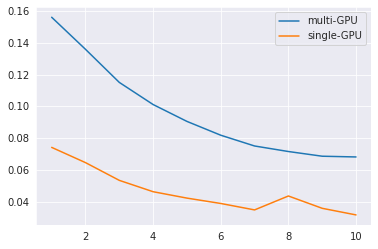

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['val_loss'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['val_loss'], 0.6), label='single-GPU')
plt.legend()

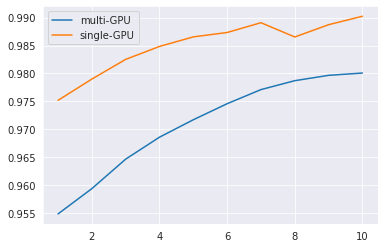

In [ ]:
plt.plot(range(1, 11), smooth(history_multi.history['val_sparse_categorical_accuracy'], 0.6), label='multi-GPU')
plt.plot(range(1, 11), smooth(history_single.history['val_sparse_categorical_accuracy'], 0.6), label='single-GPU')
plt.legend()